# Check annotator agreement on pilot test
For our pilot test, we had annotators compare `googlear` with `buscar en google` (true) and `dar google` (false).

Let's see if we can find consistent agreement among the annotations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# load data
pilot_true_sample_data = pd.read_csv('../../data/mined_reddit_comments/reddit_comments_2018_m_7_9_samples_light_verb_annotated_google_true_VERB=buscar_scalar_labels.csv', sep=',', index_col=False)
pilot_false_sample_data = pd.read_csv('../../data/mined_reddit_comments/reddit_comments_2018_m_7_9_samples_light_verb_annotated_google_false_VERB=dar_scalar_labels.csv', sep=',', index_col=False)

In [3]:
display(pilot_false_sample_data.head())

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Input.light_verb,Input.light_verb_internal,Input.light_verb_noun,Input.light_verb_phrase,Input.text_alternative,Input.equivalent_label,Input.alternative_light_verb,Answer.equivalence.label,Approve,Reject
0,3YLPJ8OXYB50RZDV99NUIEWENW2X48,306E1TDSEW8CKQJUNEOBGGXOBORDRW,Significado de frases,Tienen las dos frases el mismo significado?,"texto, lectura, espanol",$0.15,Wed Jan 15 15:23:44 PST 2020,3,BatchId:3891931;OriginalHitTemplateId:928390909;,3600,...,dar,NaN,google,da google,da google efecto tequila,-1,-1,Significado algo diferente,NaN,NaN
1,3YLPJ8OXYB50RZDV99NUIEWENW2X48,306E1TDSEW8CKQJUNEOBGGXOBORDRW,Significado de frases,Tienen las dos frases el mismo significado?,"texto, lectura, espanol",$0.15,Wed Jan 15 15:23:44 PST 2020,3,BatchId:3891931;OriginalHitTemplateId:928390909;,3600,...,dar,NaN,google,da google,da google efecto tequila,-1,-1,Mismo significado,NaN,NaN
2,3YLPJ8OXYB50RZDV99NUIEWENW2X48,306E1TDSEW8CKQJUNEOBGGXOBORDRW,Significado de frases,Tienen las dos frases el mismo significado?,"texto, lectura, espanol",$0.15,Wed Jan 15 15:23:44 PST 2020,3,BatchId:3891931;OriginalHitTemplateId:928390909;,3600,...,dar,NaN,google,da google,da google efecto tequila,-1,-1,Significado algo diferente,NaN,NaN
3,3VEI3XUC0UP2JWD2YU9QWULLDBDPRV,306E1TDSEW8CKQJUNEOBGGXOBORDRW,Significado de frases,Tienen las dos frases el mismo significado?,"texto, lectura, espanol",$0.15,Wed Jan 15 15:23:44 PST 2020,3,BatchId:3891931;OriginalHitTemplateId:928390909;,3600,...,dar,NaN,google,damos google,algunos damos google mientras nos chaqueteamos .,-1,-1,Significado algo diferente,NaN,NaN
4,3VEI3XUC0UP2JWD2YU9QWULLDBDPRV,306E1TDSEW8CKQJUNEOBGGXOBORDRW,Significado de frases,Tienen las dos frases el mismo significado?,"texto, lectura, espanol",$0.15,Wed Jan 15 15:23:44 PST 2020,3,BatchId:3891931;OriginalHitTemplateId:928390909;,3600,...,dar,NaN,google,damos google,algunos damos google mientras nos chaqueteamos .,-1,-1,Mismo significado,NaN,NaN


First test: what is the overall distribution of scores for both label sets?

We need to convert the labels to scalar values: identical = +2, different = -2.

In [76]:
# first: translate labels
es_label_var = 'Answer.equivalence.label'
es_labels_ordered = ['Significado muy diferente', 'Significado algo diferente', 'Incierto', 'Significado similar', 'Mismo significado']
en_labels_ordered = ['Very different', 'Somewhat different', 'Unsure', 'Similar', 'Same']
label_translation = dict(zip(es_labels_ordered, en_labels_ordered))
label_var = 'en_label'
pilot_true_sample_data = pilot_true_sample_data.assign(**{
    label_var : pilot_true_sample_data.loc[:, es_label_var].apply(label_translation.get)
})
pilot_false_sample_data = pilot_false_sample_data.assign(**{
    label_var : pilot_false_sample_data.loc[:, es_label_var].apply(label_translation.get)
})
## assign label values
label_val_min = -2
label_val_max = 2
label_val_range = list(range(label_val_min, label_val_max+1))
label_to_val_dict = dict(zip(en_labels_ordered, label_val_range))
pilot_true_sample_data = pilot_true_sample_data.assign(**{
    'sim_label' : pilot_true_sample_data.loc[:, label_var].apply(label_to_val_dict.get)
})
pilot_false_sample_data = pilot_false_sample_data.assign(**{
    'sim_label' : pilot_false_sample_data.loc[:, label_var].apply(label_to_val_dict.get)
})

In [73]:
print(pilot_true_sample_data.loc[:, label_var].value_counts())
print(pilot_false_sample_data.loc[:, label_var].value_counts())

Same                  24
Similar                5
Somewhat different     1
Name: en_label, dtype: int64
Same                  18
Similar                7
Somewhat different     3
Unsure                 2
Name: en_label, dtype: int64


### Compare score distributions

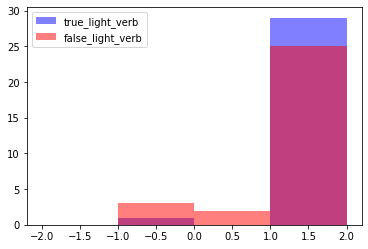

In [74]:
bins = np.linspace(label_val_min, label_val_max, label_val_max - label_val_min + 1)
plt.hist(pilot_true_sample_data.loc[:, 'sim_label'], bins, color='b', alpha=0.5, label='true_light_verb')
plt.hist(pilot_false_sample_data.loc[:, 'sim_label'], bins, color='r', alpha=0.5, label='false_light_verb')
plt.legend(loc='upper left')
plt.show()

Is there a significant difference in the distributions?

In [27]:
from scipy.stats import wilcoxon # use paired test because it's the same underlying distribution
from scipy.stats import ks_2samp
mean_diff = pilot_true_sample_data.loc[:, 'sim_label'].mean() - pilot_false_sample_data.loc[:, 'sim_label'].mean()
test_stat, p_val = wilcoxon(pilot_true_sample_data.loc[:, 'sim_label'], pilot_false_sample_data.loc[:, 'sim_label'])
print('mean difference=%.3f, significant with stat=%.3E (p=%.3f)'%(mean_diff, test_stat, p_val))
# KS test
test_stat, p_val = ks_2samp(pilot_true_sample_data.loc[:, 'sim_label'], pilot_false_sample_data.loc[:, 'sim_label'])

mean difference=0.400, significant with stat=1.150E+01 (p=0.051)


OK! Distributions are not significantly different but we do see a weak difference.

What if we look for inter-annotator agreement?

In [32]:
import krippendorff
def compute_agreement(sample_data):
    sample_data = sample_data.copy()
    task_count = sample_data.loc[:, 'HITId'].nunique()
    annotator_count = int(sample_data.shape[0] / task_count)
    label_col = 'Answer.equivalence.label'
    true_sample_annotator_data = sample_data.sort_values(['HITId', 'WorkerId']).loc[:, [label_col]]
    # replace string => numbers
    # assign fake annotator
    unique_labels = sample_data.loc[:, label_col].unique()
    label_to_num = dict(zip(unique_labels, range(len(unique_labels))))
    true_sample_annotator_data = true_sample_annotator_data.assign(**{
        label_col : true_sample_annotator_data.loc[:, label_col].apply(label_to_num.get),
        'annotator' : [i for _ in range(task_count) for i in range(annotator_count)]
    })
    reliability_data = true_sample_annotator_data.groupby('annotator').apply(lambda x: x.loc[:, label_col].values)
#     print('reliability data')
#     display(reliability_data)
    agreement = krippendorff.alpha(reliability_data=list(reliability_data))
    return agreement
true_agreement = compute_agreement(pilot_true_sample_data)
false_agreement = compute_agreement(pilot_false_sample_data)
print('true light verb agreement = %.3f'%(true_agreement))
print('false light verb agreement = %.3f'%(false_agreement))

true light verb agreement = 0.213
false light verb agreement = 0.025


The true light verb has higher agreement.

If we just look at the examples with consistent agreement for the label, do we see a difference in the score distribution?

In [75]:
def get_consistent_data(data):
    id_var = 'HITId'
    label_var = 'en_label'
    min_annotator_count = 2
    max_score_counts = data.groupby(id_var).apply(lambda x: x.loc[:, label_var].value_counts().max())
    valid_ids = max_score_counts[max_score_counts >= min_annotator_count].index
    consistent_data = data[data.loc[:, id_var].isin(valid_ids)]
    return consistent_data
min_annotator_count = 2
consistent_pilot_true_sample_data = get_consistent_data(pilot_true_sample_data)
consistent_pilot_false_sample_data = get_consistent_data(pilot_false_sample_data)
print(consistent_pilot_true_sample_data.shape[0])
print(consistent_pilot_false_sample_data.shape[0])
print(consistent_pilot_true_sample_data.loc[:, sim_var].value_counts())
print(consistent_pilot_false_sample_data.loc[:, sim_var].value_counts())

27
27
2    23
1     4
Name: sim_label, dtype: int64
 2    17
 1     6
 0     2
-1     2
Name: sim_label, dtype: int64


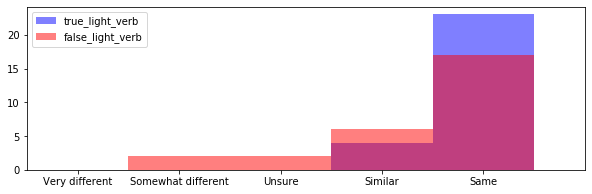

In [81]:
# plot distribution
sim_var = 'sim_label'
bins = np.linspace(label_val_min-1, label_val_max+1, label_val_max - label_val_min + 3)
bin_offset = 0.5
plt.figure(figsize=(10, 3))
plt.hist(consistent_pilot_true_sample_data.loc[:, sim_var], bins, color='b', alpha=0.5, label='true_light_verb')
plt.hist(consistent_pilot_false_sample_data.loc[:, sim_var], bins, color='r', alpha=0.5, label='false_light_verb')
plt.xticks(np.array(label_val_range) + bin_offset, en_labels_ordered)
plt.xlim(label_val_min, label_val_max+bin_offset+1)
plt.legend(loc='upper left')
plt.show()

In [40]:
# same test as before
sim_var = 'sim_label'
mean_diff = consistent_pilot_true_sample_data.loc[:, sim_var].mean() - consistent_pilot_false_sample_data.loc[:, sim_var].mean()
test_stat, p_val = wilcoxon(consistent_pilot_true_sample_data.loc[:, sim_var], consistent_pilot_false_sample_data.loc[:, sim_var])
print('mean difference=%.3f, significant with stat=%.3E (p=%.3f)'%(mean_diff, test_stat, p_val))

mean difference=0.444, significant with stat=0.000E+00 (p=0.016)


OK! Now we see that the true light verbs are more consistently marked as having the same or similar meaning.

## Old code
Binary annotation (similar/different meaning).

In [67]:
pilot_true_sample_data = pd.read_csv('../../data/mined_reddit_comments/reddit_comments_2018_m_7_9_samples_light_verb_annotated_google_labels.csv', sep=',', index_col=False)
pilot_false_sample_data = pd.read_csv('../../data/mined_reddit_comments/reddit_comments_2018_m_7_9_samples_light_verb_annotated_google_false_labels.csv', sep=',', index_col=False)

In [4]:
print(pilot_true_sample_data.columns)
display(pilot_true_sample_data.head())

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.word',
       'Input.integrated_verb', 'Input.text', 'Input.light_verb',
       'Input.light_verb_internal', 'Input.light_verb_noun',
       'Input.light_verb_phrase', 'Input.text_alternative',
       'Input.equivalent_label', 'Input.alternative_light_verb',
       'Answer.equivalence.label', 'Approve', 'Reject'],
      dtype='object')


,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Input.light_verb,Input.light_verb_internal,Input.light_verb_noun,Input.light_verb_phrase,Input.text_alternative,Input.equivalent_label,Input.alternative_light_verb,Answer.equivalence.label,Approve,Reject
0,3X4Q1O9UCKEAGDHMAGY52DPV2NQ7OM,39S3HZ8OHFJ84WIXBQLU6YSOBF77SL,Significado de frases,Tienen las dos frases el mismo significado?,"texto, lectura, espanol",$0.15,Sat Jan 04 14:45:58 PST 2020,3,BatchId:3883109;OriginalHitTemplateId:928390909;,3600,...,buscar,en,google,busca en google,busca en google efecto tequila,-1,-1,Mismo significado,NaN,NaN
1,3X4Q1O9UCKEAGDHMAGY52DPV2NQ7OM,39S3HZ8OHFJ84WIXBQLU6YSOBF77SL,Significado de frases,Tienen las dos frases el mismo significado?,"texto, lectura, espanol",$0.15,Sat Jan 04 14:45:58 PST 2020,3,BatchId:3883109;OriginalHitTemplateId:928390909;,3600,...,buscar,en,google,busca en google,busca en google efecto tequila,-1,-1,Mismo significado,NaN,NaN
2,3X4Q1O9UCKEAGDHMAGY52DPV2NQ7OM,39S3HZ8OHFJ84WIXBQLU6YSOBF77SL,Significado de frases,Tienen las dos frases el mismo significado?,"texto, lectura, espanol",$0.15,Sat Jan 04 14:45:58 PST 2020,3,BatchId:3883109;OriginalHitTemplateId:928390909;,3600,...,buscar,en,google,busca en google,busca en google efecto tequila,-1,-1,Significado diferente,NaN,NaN
3,3ZXV7Q5FKEGMMHZP2UNQV58VBXQCFY,39S3HZ8OHFJ84WIXBQLU6YSOBF77SL,Significado de frases,Tienen las dos frases el mismo significado?,"texto, lectura, espanol",$0.15,Sat Jan 04 14:45:58 PST 2020,3,BatchId:3883109;OriginalHitTemplateId:928390909;,3600,...,buscar,en,google,buscamos en google,algunos buscamos en google mientras nos chaque...,-1,-1,Significado diferente,NaN,NaN
4,3ZXV7Q5FKEGMMHZP2UNQV58VBXQCFY,39S3HZ8OHFJ84WIXBQLU6YSOBF77SL,Significado de frases,Tienen las dos frases el mismo significado?,"texto, lectura, espanol",$0.15,Sat Jan 04 14:45:58 PST 2020,3,BatchId:3883109;OriginalHitTemplateId:928390909;,3600,...,buscar,en,google,buscamos en google,algunos buscamos en google mientras nos chaque...,-1,-1,Mismo significado,NaN,NaN


Let's get some summary stats first: how many HITs per unique annotator?

In [78]:
print('true sample data')
print('%d annotations per HIT'%(pilot_true_sample_data.loc[:, 'HITId'].value_counts().mean()))
print('%.3f +/- %.3f HITs per annotator'%(pilot_true_sample_data.loc[:, 'WorkerId'].value_counts().mean(), pilot_true_sample_data.loc[:, 'WorkerId'].value_counts().std()))
print('false sample data')
print('%d annotations per HIT'%(pilot_false_sample_data.loc[:, 'HITId'].value_counts().mean()))
print('%.3f +/- %.3f HITs per annotator'%(pilot_false_sample_data.loc[:, 'WorkerId'].value_counts().mean(), pilot_false_sample_data.loc[:, 'WorkerId'].value_counts().std()))

true sample data
3 annotations per HIT
2.308 +/- 2.213 HITs per annotator
false sample data
3 annotations per HIT
2.308 +/- 2.057 HITs per annotator


OK! Not many people finished the whole task. It may be too taxing.

How long per hit?

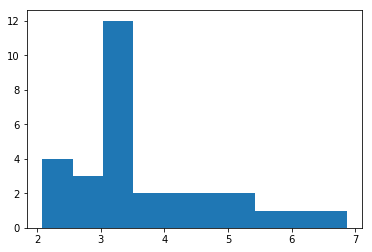

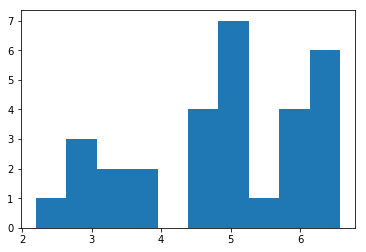

In [86]:
plt.hist(np.log(pilot_true_sample_data.loc[:, 'WorkTimeInSeconds']))
plt.show()
plt.hist(np.log(pilot_false_sample_data.loc[:, 'WorkTimeInSeconds']))
plt.show()

In [80]:
np.e**5

148.41315910257657

For true samples: most people take around $e^{3}=20$ seconds per task, which gets them 0.15/task * 3 task / minute * 60 minute / hour = $27 / hour. Far above minimum wage.

For false samples: most people take around $e^{5}=148$ seconds per task, which gets them 0.15/task * 0.405 task / minute * 60 minute / hour = $3.64 / hour. Far below minimum wage!

Which tasks take the longest?

In [91]:
true_sample_time_per_task = pilot_true_sample_data.groupby('HITId').apply(lambda x: x.loc[:, 'WorkTimeInSeconds'].mean()).sort_values(inplace=False, ascending=False)
false_sample_time_per_task = pilot_false_sample_data.groupby('HITId').apply(lambda x: x.loc[:, 'WorkTimeInSeconds'].mean()).sort_values(inplace=False, ascending=False)
display(true_sample_time_per_task.head(5))
print('\n'.join(pilot_true_sample_data[pilot_true_sample_data.loc[:, 'HITId'].isin(true_sample_time_per_task.head(5).index)].loc[:, 'Input.text_alternative'].unique()))
display(false_sample_time_per_task.head(5))
print('\n'.join(pilot_false_sample_data[pilot_false_sample_data.loc[:, 'HITId'].isin(false_sample_time_per_task.head(5).index)].loc[:, 'Input.text_alternative'].unique()))

HITId
3EKZL9T8ZBE60DQVXKBQYQK8RC3CHW    323.666667
322ZSN9Z6JCTAI4B4ZMXTBB8ATH4TL    193.333333
3LG268AV4BYYM5OCPGTF2IMHZXEERO    115.000000
373L46LKQAYKAHX9DXV9YMDV9DGJKL     74.666667
3X4Q1O9UCKEAGDHMAGY52DPV2NQ7OM     72.333333
dtype: float64

busca en google efecto tequila
tipo que los tipos buscan en google hacen un video y los pibes viralizan .
si no lo sacan por el contexto mejor , buscan en google y aprenden .
 te repito , buscaste en google alguna vez crisis migratoria ?
 busqué en google eso , parece que es algo así jaja


HITId
3087LXLJ7P82SP49QEU6046U28U0FU    494.666667
35U0MRQMVMZCR3IISE1L8R5YO5XVO2    317.000000
3CMV9YRYQ6TVUNFRYX7ADMQAYDLLJQ    308.333333
3WRBLBQ2HU086P041Y0OIP663NU0GT    279.666667
3D1TUISJXLS2I2IFPTEBS87TYPPIU5    261.666667
dtype: float64

haz google efecto tequila
algunos hacemos google mientras nos chaqueteamos .
si me decis que no hiciste google como escribir el apellido no te creo .
 te repito , hiciste google alguna vez crisis migratoria ?
 hice google eso , parece que es algo así jaja


The tasks that took the longest had somewhat vague context.

In [51]:
import numpy as np
import krippendorff
def compute_agreement(sample_data):
    task_count = sample_data.loc[:, 'HITId'].nunique()
    annotator_count = int(sample_data.shape[0] / task_count)
    label_col = 'Answer.equivalence.label'
    true_sample_annotator_data = sample_data.sort_values(['HITId', 'WorkerId']).loc[:, [label_col]]
    # replace string => numbers
    # assign fake annotator
    unique_labels = sample_data.loc[:, label_col].unique()
    label_to_num = dict(zip(unique_labels, range(len(unique_labels))))
    # label_to_num['Incierto'] = np.nan
    true_sample_annotator_data = true_sample_annotator_data.assign(**{
        label_col : true_sample_annotator_data.loc[:, label_col].apply(label_to_num.get),
        'annotator' : [i for _ in range(task_count) for i in range(annotator_count)]
    })
    reliability_data = true_sample_annotator_data.groupby('annotator').apply(lambda x: x.loc[:, label_col].values)
    print('reliability data')
    display(reliability_data)
    agreement = krippendorff.alpha(reliability_data=list(reliability_data))
    return agreement
true_agreement = compute_agreement(pilot_true_sample_data)
false_agreement = compute_agreement(pilot_false_sample_data)
print('true agreement = %.3f'%(true_agreement))
print('false agreement = %.3f'%(false_agreement))

reliability data


annotator
0    [1, 1, 0, 1, 1, 0, 0, 0, 0, 0]
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
2    [0, 0, 0, 1, 1, 1, 1, 0, 0, 2]
dtype: object

reliability data


annotator
0    [1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
1    [1, 0, 0, 1, 0, 0, 0, 1, 1, 1]
2    [1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
dtype: object

true agreement = 0.030
false agreement = 0.194


In general, the "false" data has more consistent agreement than the "true" data.

Does the "true" data have more labels for "same meaning"?

In [52]:
label_col = 'Answer.equivalence.label'
print(pilot_true_sample_data.loc[:, label_col].value_counts())
print(pilot_false_sample_data.loc[:, label_col].value_counts())

Mismo significado        20
Significado diferente     9
Incierto                  1
Name: Answer.equivalence.label, dtype: int64
Mismo significado        18
Significado diferente    12
Name: Answer.equivalence.label, dtype: int64


How many examples had at least 2 annotators agreeing with the same meaning?

In [58]:
## same meaning
same_meaning_label = 'Mismo significado'
min_annotator_cutoff = 2
true_sample_same_meaning_counts = pilot_true_sample_data.groupby('HITId').apply(lambda x: x[x.loc[:, label_col]==same_meaning_label].shape[0])
false_sample_same_meaning_counts = pilot_false_sample_data.groupby('HITId').apply(lambda x: x[x.loc[:, label_col]==same_meaning_label].shape[0])
print('%d/%d HITs in true light verb data with >=%d annotators indicating "same meaning"'%(true_sample_same_meaning_counts[true_sample_same_meaning_counts>=min_annotator_cutoff].shape[0], true_sample_same_meaning_counts.shape[0], min_annotator_cutoff))
print('%d/%d HITs in false light verb data with >=%d annotators indicating "same meaning"'%(false_sample_same_meaning_counts[false_sample_same_meaning_counts>=min_annotator_cutoff].shape[0], false_sample_same_meaning_counts.shape[0], min_annotator_cutoff))
## different meaning
diff_meaning_label = 'Significado diferente'
min_annotator_cutoff = 2
true_sample_diff_meaning_counts = pilot_true_sample_data.groupby('HITId').apply(lambda x: x[x.loc[:, label_col]==diff_meaning_label].shape[0])
false_sample_diff_meaning_counts = pilot_false_sample_data.groupby('HITId').apply(lambda x: x[x.loc[:, label_col]==diff_meaning_label].shape[0])
print('%d/%d HITs in true light verb data with >=%d annotators indicating "different meaning"'%(true_sample_diff_meaning_counts[true_sample_diff_meaning_counts>=min_annotator_cutoff].shape[0], true_sample_diff_meaning_counts.shape[0], min_annotator_cutoff))
print('%d/%d HITs in false light verb data with >=%d annotators indicating "different meaning"'%(false_sample_diff_meaning_counts[false_sample_diff_meaning_counts>=min_annotator_cutoff].shape[0], false_sample_diff_meaning_counts.shape[0], min_annotator_cutoff))

7/10 HITs in true light verb data with >=2 annotators indicating "same meaning"
6/10 HITs in false light verb data with >=2 annotators indicating "same meaning"
2/10 HITs in true light verb data with >=2 annotators indicating "different meaning"
4/10 HITs in false light verb data with >=2 annotators indicating "different meaning"


- Slightly more annotators indicating "same meaning" for true light verbs
- Slightly fewer annotators indicating "different meaning" for true light verbs

In [42]:
reliability_data_str = (
    "*    *    *    *    *    3    4    1    2    1    1    3    3    *    3",  # coder A
    "1    *    2    1    3    3    4    3    *    *    *    *    *    *    *",  # coder B
    "*    *    2    1    3    4    4    *    2    1    1    3    3    *    4",  # coder C
)
print('\n'.join(reliability_data_str))
print('')

reliability_data = [[np.nan if v == '*' else int(v) for v in coder.split()] for coder in reliability_data_str]
print(reliability_data)
print("Krippendorff's alpha for nominal metric: ", krippendorff.alpha(reliability_data=reliability_data,
                                                                      level_of_measurement='nominal'))

*    *    *    *    *    3    4    1    2    1    1    3    3    *    3
1    *    2    1    3    3    4    3    *    *    *    *    *    *    *
*    *    2    1    3    4    4    *    2    1    1    3    3    *    4

[[nan, nan, nan, nan, nan, 3, 4, 1, 2, 1, 1, 3, 3, nan, 3], [1, nan, 2, 1, 3, 3, 4, 3, nan, nan, nan, nan, nan, nan, nan], [nan, nan, 2, 1, 3, 4, 4, nan, 2, 1, 1, 3, 3, nan, 4]]
Krippendorff's alpha for nominal metric:  0.691358024691358
